In [1]:
NO_OF_PERSONS = 500

In [38]:
import networkx as nx
from networkx.drawing.nx_agraph import write_dot, graphviz_layout
import random
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import csv
import pandas as pd
import numpy as np
import collections

no_human_nodes = 500
no_seed = 125
son_rate = 30 ## Percentage of population that have father/son
rate_partnered = 85

ModuleNotFoundError: No module named 'tabulate'

In [3]:
G = nx.DiGraph()
random.seed(no_seed)

names = pd.read_csv('names.csv')
surnames = pd.read_csv('surnames.csv')
age = pd.read_csv('pop_by_age.csv')

age['nprein'] = (100*age.preindex/max(age.preindex)).astype(int)

In [4]:
def getage(region):
    line_age = age[(age.nprein>region)].head(1)
    minimum_age = line_age['agemin'].iloc[0].astype(int)
    maximum_age = line_age['agemax'].iloc[0].astype(int)
    
    return random.randint(minimum_age,maximum_age)

In [5]:
## Build nodes
ppl = names.sample(no_human_nodes,random_state=no_seed)
selected_names    = list(ppl['name'])
selected_sex      = list(ppl['sex'])

selected_surnames = list(surnames.sample(no_human_nodes,random_state=123)['name'])
for x in range(no_human_nodes):
    this_one_surname = selected_surnames[x]
    
    #G.add_node(x,name = this_one_name['name'].iloc[0]+" "+this_one_surname['name'].iloc[0])
    G.add_node(x,name = selected_names[x])
    G.nodes[x]['gender'] = selected_sex[x]
    #G.nodes[x]['aggressive'] = round(random.random(),3)
    #G.nodes[x]['habitude'] = round(random.random(),3)
    
    G.nodes[x]['age'] = getage(random.randint(0,99))
    

In [6]:
## Build Relationship Partnered BOY TO GIRL
MIN_AGE_COUPLE = 15
MAX_AGE_COUPLE_DIFFERENCE = 10

boy  = list(n for n in G if G.node[n]['gender']=='boy' )
girl = list(n for n in G if G.node[n]['gender']=='girl')
for x in boy:
    if (random.randrange(0,100)<rate_partnered): # 75% are partnered
        if G.node[x]['age']>MIN_AGE_COUPLE and len(girl)>0: ## if boy is of age and girls are available
            age_min = max(G.node[x]['age']-MAX_AGE_COUPLE_DIFFERENCE,0)
            age_max = G.node[x]['age']+MAX_AGE_COUPLE_DIFFERENCE
            
            girl_avail = list(n for n in girl if G.node[n]['gender']=='girl' and G.node[n]['age']>=age_min and G.node[n]['age']<=age_max)
            y = random.choice(girl_avail) ## Pick a random girl
            girl.remove(y)  ## Remove selected girl from available
            G.add_edge(x,y, partner='true',weight=0) ## Partner them

In [7]:
### FIND PARTNER OF

def partner_of(noden):
    for (u,v) in list(G.out_edges(noden)):
        edge_data = G.get_edge_data(u,v)
        if 'partner' in edge_data:
            if u == noden:
                return v
            else:
                return u

    for (u,v) in list(G.in_edges(noden)):
        edge_data = G.get_edge_data(u,v)
        if 'partner' in edge_data:
            if u == noden:
                return v
            else:
                return u
    return None

In [8]:
def sons_of(noden):
    sons=[]
    for (u,v) in G.in_edges(noden):
        edge_data = G.get_edge_data(u,v)
        if 'son' in edge_data:
            sons.append(u)
    return sons

In [9]:
def parents_of(noden):
    parents=[]
    for (u,v) in G.out_edges(noden):
        edge_data = G.get_edge_data(u,v)
        if 'son' in edge_data:
            #print(noden,u,v,edge_data,G.node[u]['age'],G.node[v]['age'])
            parents.append(v)
    return parents

def siblings_of(noden):
    siblings=[]
    parents = parents_of(a)
    if len(parents)>0:
        siblings = sons_of(parents[0])
        #print(siblings)
    return siblings


In [10]:
## Assign sons and daughters
AGE_FOR_PART = 15

for x in G.node:
    ppl = list(n for n in G if (G.node[n]['age']>G.node[x]['age']+AGE_FOR_PART) and (G.node[n]['age']<G.node[x]['age']+50))
    precentage_chance_of_parent = int(100*len(ppl)/NO_OF_PERSONS)  
    
    if random.randint(0,70)<precentage_chance_of_parent:
        y = random.choice(ppl)
        z = partner_of(y)
        G.add_edge(x,y, son='true',weight=0)
        if z != None:
            G.add_edge(x,z, son='true',weight=0)
    

In [11]:
for a in G:
    siblings = siblings_of(a)
    if len(siblings)>0:
        parents = parents_of(a)
        print(a,parents, G.node[a]['age'], [G.node[x]['age'] for x in parents])
        print(a,siblings,G.node[a]['age'], [G.node[x]['age'] for x in siblings])
        print("----------------------------------------------------------------")

0 [18, 226] 31 [61, 51]
0 [0] 31 [31]
----------------------------------------------------------------
6 [352, 462] 11 [48, 40]
6 [6] 11 [11]
----------------------------------------------------------------
19 [21, 327] 20 [60, 62]
19 [19] 20 [20]
----------------------------------------------------------------
21 [10, 96] 60 [77, 83]
21 [21, 63, 354] 60 [60, 29, 52]
----------------------------------------------------------------
22 [316, 397] 43 [62, 58]
22 [22] 43 [43]
----------------------------------------------------------------
26 [496, 407] 17 [49, 54]
26 [26, 120] 17 [17, 21]
----------------------------------------------------------------
29 [65, 272] 4 [48, 45]
29 [29, 303] 4 [4, 16]
----------------------------------------------------------------
36 [139, 12] 33 [54, 51]
36 [36] 33 [33]
----------------------------------------------------------------
39 [369, 31] 57 [80, 77]
39 [39, 384] 57 [57, 31]
----------------------------------------------------------------
41 [350, 

In [12]:
def show_graph_withattr(item1,item2):
    node_labels = nx.get_node_attributes(G,item1)
    node_labels2 = nx.get_node_attributes(G,item2)

    ## For viewing only we make one dictionary with concatenated values
    result = {}
    for key in (node_labels.keys() | node_labels2.keys()):
        if key in node_labels:  result.setdefault(key, []).append(node_labels[key])
        if key in node_labels2: result.setdefault(key, []).append(node_labels2[key])

    nx.draw(G, with_labels=True, font_weight='bold', labels = result)
    
def query_node_byname(name):
    for u,v in G.nodes(data=True):
        if v['name']==name:
            print(u,v)
    
def show_graph(GH,age_show=True):
    pos = nx.kamada_kawai_layout(GH)
    
    if age_show == False:
        node_labels = nx.get_node_attributes(GH,'name')
    else:
        node_labels = nx.get_node_attributes(GH,'age')
        
    plt.figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
    
    
    nx.draw_networkx_nodes(GH,pos,nodelist=list(GH.nodes),node_color='g')
    nx.draw_networkx_edges(GH,pos,edgelist=[(u,v) for u,v,d in GH.edges(data='partner') if d!=None], edge_color='b')
    nx.draw_networkx_edges(GH,pos,edgelist=[(u,v) for u,v,d in GH.edges(data='son') if d!=None], edge_color='r')
    nx.draw_networkx_labels(GH, pos, node_labels, font_size=16)

In [13]:
## Show largest Family
def show_largest_family(age_show=False):
    node_in_largest_subgraph = list(max(nx.weakly_connected_components(G), key=len))
    subH = G.subgraph(node_in_largest_subgraph)
    show_graph(subH,age_show=age_show)

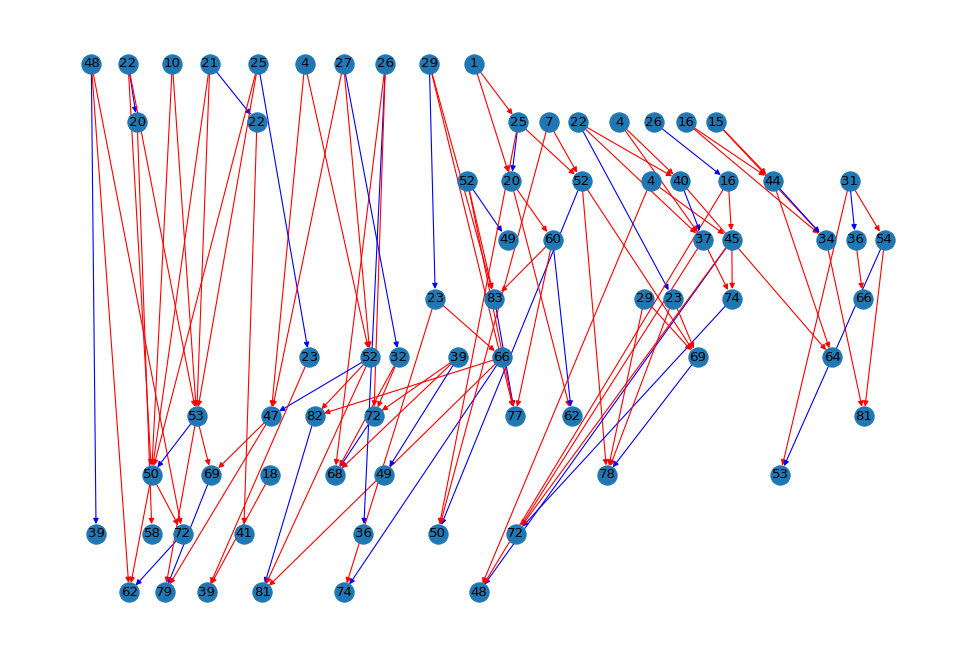

In [14]:
def show_family(show_age=False):
    
    node_in_largest_subgraph = list(max(nx.weakly_connected_components(G), key=len))
    
    subH = G.subgraph(node_in_largest_subgraph)
    
    
    agedict = {}
    if show_age:
        for a  in subH:
            agedict[a]=G.node[a]['age']
    else:
        for a  in subH:
            agedict[a]=a
    
    colors=[]
    for a in subH.edges:
        if "son" in G.edges[a]:
            colors.append('r')
        else:
            colors.append('b')
        
    pos =graphviz_layout(subH, prog='dot')
    plt.figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
    nx.draw(subH, pos, labels=agedict, with_labels=True, arrows=True, edge_color=colors)
        
show_family(show_age=True)   

## Assign households


#### Rules

1. Age < 15 live with parents (if available) Rate 99%
2. 15 < Age < 30 live with parents (if available and no sons) Rate 40%
3. 30 < Age < 40 live with parents (if available and no sons) Rate 10%
4. Age > 70 and alone live with sons Rate 75%
5. Partners live together Rate 99%
6. Lone siblings live together rate 100%

##### Sizes
Household sizes

1. 2 room - 1 person
2. 3 room - 2 person
3. 5 room - 3-7 person
4. 6-10 room - 8 person or more


In [15]:
def number_of_homes():
    locs=[]
    for a in G:
        locs.append( G.node[a]['home'] )   
    print(len(set(locs)))
    
    
def set_of_homes():
    locs=[]
    for a in G:
        locs.append( G.node[a]['home'] )   
    return set(locs)

def lone_dwellers():
    
    ## list Locations
    locs = []
    for a in G:
        locs.append(G.node[a]['home'])
    
    ### list one person locations
    one_person_hse = [x for x in locs if locs.count(x)==1]

    ### list people living alone
    ppl=[]
    for a in one_person_hse: 
        thisloc=[]
        for b in G:
            if G.node[b]['home']==a:
                ppl.append(b)
    return ppl

In [16]:
### Start with Location per Person
for a in G:
    G.node[a]['home']=a
    
##Rule 5
for a in G:
    partner = partner_of(a)
    if partner!=None:
        G.node[partner]['home'] = G.node[a]['home']
        
number_of_homes()

for a in G:
    sons = sons_of(a)
    for son in sons:
        if G.node[son]['age']<15: ##Rules 1
            G.node[son]['home'] = G.node[a]['home']
            
        elif G.node[son]['age']<30 and random.randint(0,100)<60 and len(sons_of(son))==0: ##Rules 2
            G.node[son]['home'] = G.node[a]['home']
            partner = partner_of(son)
            if partner!=None:
                G.node[partner]['home'] = G.node[a]['home']
                
        elif G.node[son]['age']<40 and random.randint(0,100)<30 and len(sons_of(son))==0: ##Rules 3
            G.node[son]['home'] = G.node[a]['home']
            partner = partner_of(son)
            if partner!=None:
                G.node[partner]['home'] = G.node[a]['home']


##Rule 4
for a in G:
    if partner_of(a)==None and G.node[a]['age']>69:
        sons = sons_of(a)
        if len(sons)>0:
            G.node[a]['home']=G.node[sons[0]]['home']
            
##Rule 6:Lone Siblings can live with each other
loners = lone_dwellers()
for a in loners:
    
    if a in lone_dwellers(): ## Recheck if unit is in lone-dwellers, because we remove candidates within loop
        siblings = siblings_of(a) ## Find brothers and sisters
        if len(siblings)>0:
            candidates = []
            for brosis in siblings:
                if brosis in loners: ## if brothers and sisters are also Lonedwellers
                    candidates.append(brosis)
            if len(candidates)>0:
                G.node[candidates[0]]['home'] = G.node[a]['home']
number_of_homes()

319
228


In [17]:
vernac = []
for home in set_of_homes():
    inhabitants = 0
    for a in G:
        if G.node[a]['home']==home:
            inhabitants = inhabitants+1
    vernac.append(inhabitants)

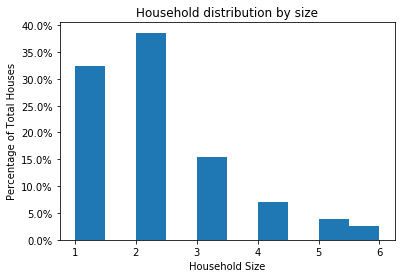

In [25]:
plt.xlabel("Household Size")
plt.ylabel("Percentage of Total Houses")
plt.title("Household distribution by size")
plt.hist(vernac, weights=np.ones(len(vernac)) / len(vernac))

plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

#n, bins, patches = plt.hist(vernac, facecolor='blue', alpha=0.5)
#plt.show()

### Table of Residential Locations

In [44]:
tabul = []
for a in sorted(set(vernac)):
    tabul.append([a,vernac.count(a)])
tabul_pd = pd.DataFrame(tabul)
tabul_pd.columns = ["Household Size", "No of Households"]
print(tabul_pd.to_string(index=False))

 Household Size  No of Households
              1                74
              2                88
              3                35
              4                16
              5                 9
              6                 6


In [19]:
### Workers >18 <61
workers = []
for a in G:
    
    if G.node[a]['age']>18 and G.node[a]['age']<62:
        workers.append(a)


In [20]:
def all_workers_deployed():
    for a in workers:
        if 'work' not in G.node[a]:
            return False
    return True

def get_random_worker_undeployed():
    
    if not all_workers_deployed():
        
        nondeplwork=[]
        for a in workers:
            if 'work' not in G.node[a]:
                nondeplwork.append(a)
                
        return random.choice(nondeplwork)
            

#### Work Location
1. Same as home location probability 10%
2. Employed rate 95%  -- EMPLOYED_RATE
EMPLOYED_RATE = 95

3. New location by Size
   - 0 5%    5
   - 1 48%   53
   - 2 24%   77
   - 3 12%   89
   - 4 6%    95
   - 5 3%    98
   - 6-10  -100%
    

In [21]:
loc=NO_OF_PERSONS

work_locs={}
unemployed = 0
while not all_workers_deployed():
    employeerange=np.random.choice(np.arange(0, 7), p=[0.05,0.48,0.24,0.12,0.06,0.03,0.02])
    
    if employeerange==0:
        this_worker = get_random_worker_undeployed()
        G.node[this_worker]['work']=0
        unemployed = unemployed + 1
        
    else:
        work_locs[loc] = 0
        for employees in range(employeerange):
            this_worker = get_random_worker_undeployed()
            if this_worker != None:
                work_locs[loc] = work_locs[loc] + 1
                G.node[this_worker]['work']=loc

        loc=loc+1 

In [22]:
def CountFrequency(my_list): 
  
    # Creating an empty dictionary  
    freq = {} 
    for item in my_list: 
        if (item in freq): 
            freq[item] += 1
        else: 
            freq[item] = 1
    freq = collections.OrderedDict(sorted(freq.items()))
    for key, value in freq.items(): 
        print ("% d : % d"%(key, value)) 

CountFrequency(work_locs.values())
print("Unemployed", unemployed)

 1 :  71
 2 :  38
 3 :  14
 4 :  9
 5 :  6
 6 :  1
Unemployed 10


### Special Locations (number depend on city-size)


High capacity locations include
Sites have a 1km max range to clients
1. Market (max 50) work-errand 
2. School (max 50) work-errand 
3. Temple (max 50) work-errand

Medium capacity locations include
Sites have a 5km max range to clients
4. Administration (10)
5. Shops / Restaurants
6. Police Stations 
7. Civil Protection

Infrastructure (20m)
10. Roads 
11. Plumbing / Water Source

### Build a Map - Location (footprint) + storeys


In [23]:
### Function for Births

In [24]:
### Function for Deaths

### Works

1. Health
2. Food
3. Water
4. Construction

5. Social Accumulation
6. Security / Policing

7. Education
